In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

from scipy.stats import t
from scipy import stats
np.random.seed(42)


#### Part 2: A continuous-time model (CTMC model)

\[
Q = 
\begin{bmatrix}
-0.0085 & 0.005 & 0.0025 & 0 & 0.001 \\
0 & -0.014 & 0.005 & 0.004 & 0.005 \\
0 & 0 & -0.008 & 0.003 & 0.005 \\
0 & 0 & 0 & -0.009 & 0.009 \\
0 & 0 & 0 & 0 & 0
\end{bmatrix}
\]

Simulate 1000 women, all starting in state 1, until death. Summarize the
lifetime distribution after surgery, for example in a histogram. Report the
mean, along with a cofidence interval, and the standard deviation, also
with a cofidence interval. In what proportion of women has the cancer
reappeared distantly after 30.5 months?

we astarts in state 1, at each state we waits a random time from a Exponential(rate=-qii). We jump to another state with probabilities: $
\text{Prob}(i \rightarrow j) = \frac{q_{ij}}{-q_{ii}}
$
Repeat until they reach state 4 (death).

In [2]:
import numpy as np

# Transition-rate matrix Q
Q = np.array([
    [-0.0085, 0.005, 0.0025, 0, 0.001],
    [0, -0.014, 0.005, 0.004, 0.005],
    [0, 0, -0.008, 0.003, 0.005],
    [0, 0, 0, -0.009, 0.009],
    [0, 0, 0, 0, 0]  # Absorbing state (death)
])

np.random.seed(42)

def simulate_path(Q):
    current_state = 0  # Start at state 1
    path = [current_state + 1]
    times = [0]
    total_time = 0

    while Q[current_state, current_state] != 0:  # Stop if in death state
        qii = -Q[current_state, current_state]
        time_in_state = np.random.exponential(scale=1/qii)
        total_time += time_in_state
        times.append(total_time)

        # Compute jump probabilities
        probs = Q[current_state].copy()
        probs[current_state] = 0
        probs = probs / qii

        next_state = np.random.choice(len(Q), p=probs)
        current_state = next_state
        path.append(current_state + 1)

    return path, times

# Run the simulation
path, times = simulate_path(Q)

# Print results
for i in range(len(path)-1):
    print(f"State {path[i]} --> State {path[i+1]} after {times[i+1] - times[i]:.2f} months")

print(f"\nTotal time until reaching death state (state {path[-1]}): {times[-1]:.2f} months")


State 1 --> State 5 after 55.21 months

Total time until reaching death state (state 5): 55.21 months


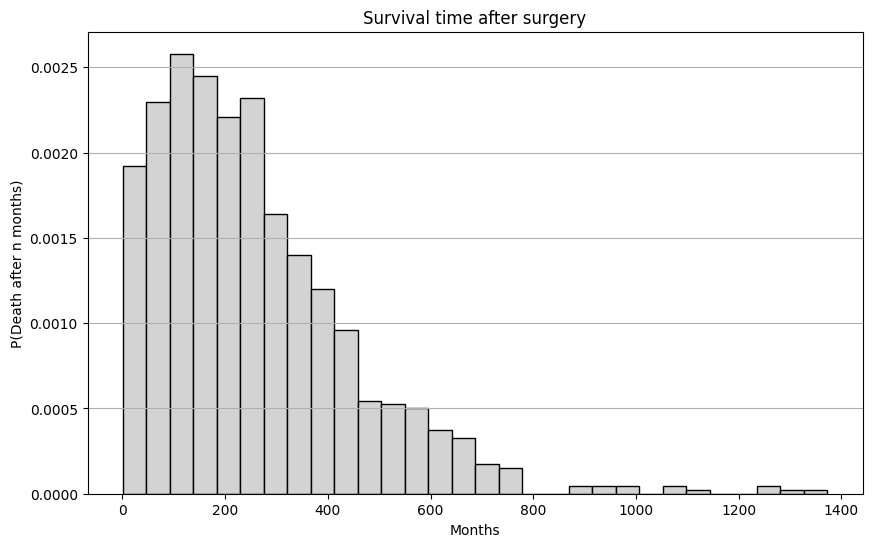

Mean survival time: 256.37 months
Standard deviation: 194.38 months
95% CI: (244.31, 268.43)
Proportion with distant recurrence after 30.5 months: 59.9%


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t as t_dist


# Transition rate matrix Q
Q = np.array([
    [-0.0085, 0.005, 0.0025, 0.0, 0.001],
    [0.0, -0.014, 0.005, 0.004, 0.005],
    [0.0, 0.0, -0.008, 0.003, 0.005],
    [0.0, 0.0, 0.0, -0.009, 0.009],
    [0.0, 0.0, 0.0, 0.0, 0.0]
])

def simulate_ctmc(Q, start_state=0):
    state = start_state
    time = 0.0
    path = []  # store (state, time_entered)
    visited_distant_after_30_5 = False
    
    while state != 4:
        rate = -Q[state, state]
        if rate == 0:
            break
        dt = np.random.exponential(1 / rate)
        time += dt
        path.append((state, time))
        
        probs = Q[state].copy()
        probs[state] = 0
        probs = probs / rate
        state = np.random.choice(len(Q), p=probs)
        
        if time > 30.5 and state in [2, 3]:  # state 3 or 4 (index 2 or 3)
            visited_distant_after_30_5 = True
    
    return time, visited_distant_after_30_5

# Simulate 1000 women
n = 1000
lifetimes = []
distant_after_30_5 = []

np.random.seed(42)
for _ in range(n):
    t, distant = simulate_ctmc(Q)
    lifetimes.append(t)
    distant_after_30_5.append(distant)

lifetimes = np.array(lifetimes)
distant_after_30_5 = np.array(distant_after_30_5)

# Calculate statistics
mean_lifetime = np.mean(lifetimes)
std_lifetime = np.std(lifetimes, ddof=1)
ci_half_width = t_dist.ppf(0.975, df=n-1) * std_lifetime / np.sqrt(n)
ci_lower = mean_lifetime - ci_half_width
ci_upper = mean_lifetime + ci_half_width
distant_rate = np.mean(distant_after_30_5) * 100

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(lifetimes, bins=30, density=True, color='lightgray', edgecolor='black')
plt.title("Survival time after surgery")
plt.xlabel("Months")
plt.ylabel("P(Death after n months)")
plt.grid(True, axis='y')
plt.show()

# Output
print(f"Mean survival time: {mean_lifetime:.2f} months")
print(f"Standard deviation: {std_lifetime:.2f} months")
print(f"95% CI: ({ci_lower:.2f}, {ci_upper:.2f})")
print(f"Proportion with distant recurrence after 30.5 months: {distant_rate:.1f}%")


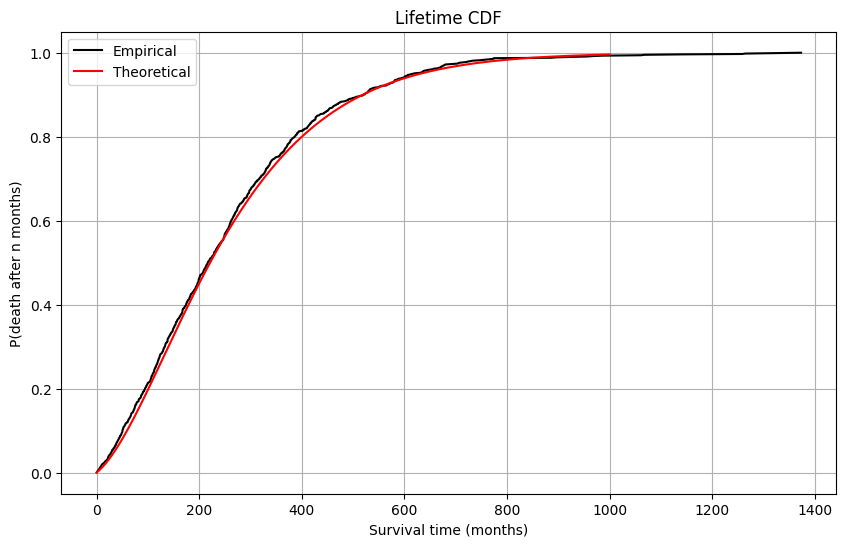

{'KS Test Statistic': np.float64(0.024),
 'p-value': np.float64(0.611),
 '95% Threshold (1.358)': 'Accept H0'}

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest
from scipy.linalg import expm

# Full Q matrix (5x5)
Q = np.array([
    [-0.0085, 0.005, 0.0025, 0.0, 0.001],
    [0.0, -0.014, 0.005, 0.004, 0.005],
    [0.0, 0.0, -0.008, 0.003, 0.005],
    [0.0, 0.0, 0.0, -0.009, 0.009],
    [0.0, 0.0, 0.0, 0.0, 0.0]
])

# Submatrix Qs (remove absorbing state)
Qs = Q[:4, :4]
p0 = np.array([[1, 0, 0, 0]])  # Initial distribution
ones = np.ones((4, 1))        # Column vector of ones

# Time range to compute theoretical CDF
time_points = np.linspace(0, 1000, 500)
F_theoretical = []

for t in time_points:
    matrix_exp = expm(Qs * t)        # exp(Qs * t)
    Ft = 1 - p0 @ matrix_exp @ ones  # F_T(t)
    F_theoretical.append(Ft[0, 0])

# Simulate empirical CTMC lifetimes
def simulate_ctmc(Q, start_state=0):
    state = start_state
    time = 0.0
    while state != 4:
        rate = -Q[state, state]
        if rate == 0:
            break
        dt = np.random.exponential(1 / rate)
        time += dt

        probs = Q[state].copy()
        probs[state] = 0
        probs = probs / rate
        state = np.random.choice(len(Q), p=probs)

    return time

# Simulate 1000 lifetimes
np.random.seed(42)
n = 1000
lifetimes = np.array([simulate_ctmc(Q) for _ in range(n)])
lifetimes_sorted = np.sort(lifetimes)
empirical_cdf = np.arange(1, n + 1) / n

# Interpolate theoretical CDF at empirical points
from scipy.interpolate import interp1d
theoretical_interp = interp1d(time_points, F_theoretical, kind='linear', fill_value="extrapolate")
theoretical_at_empirical = theoretical_interp(lifetimes_sorted)

# Kolmogorov–Smirnov test
ks_stat, p_value = kstest(lifetimes, theoretical_interp)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(lifetimes_sorted, empirical_cdf, label="Empirical", color='black')
plt.plot(time_points, F_theoretical, label="Theoretical", color='red')
plt.title("Lifetime CDF")
plt.xlabel("Survival time (months)")
plt.ylabel("P(death after n months)")
plt.legend()
plt.grid(True)
plt.show()

# Return key results
{
    "KS Test Statistic": round(ks_stat, 3),
    "p-value": round(p_value, 4),
    "95% Threshold (1.358)": "Accept H0" if ks_stat < 1.358 else "Reject H0"
}


This means there is no statistically significant difference between the simulated survival times and the theoretical continuous phase-type distribution. The CTMC model effectively captures the survival time behavior.